# **Chapter 2: Complex Peptide Embeddings**

In [Chapter 1](https://colab.research.google.com/drive/16X24UTXu850_VKFmL3lXztfjqunF4Ck2?usp=sharing), we discussed several basic Machine Learning (ML) embedding techniques:


1.   Single-number embeddings (a float)
2.   Fractional amino acid composition (an array)
3.   One-hot encoding (a 2D matrix)


These encoding methods translate amino acid sequences into numeric representations. They are fairly simple to conceptualize and to code. However, they have some shortcomings in representing proteomic data. A more complex and descriptive embedding often requires us to combine multiple encodings into higher-dimensional data structures---a set of matricies known as a **tensor**---to create a more rich and complete representation.



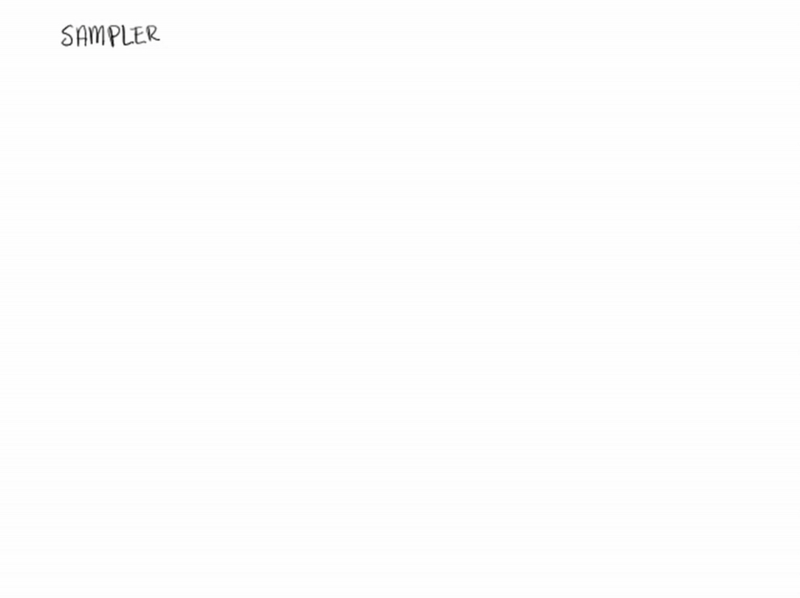

In this Chapter, **we will learn a new embedding technique that creates a tensor**. We note that the first three levels from Chapter 1 were intuitive and simple to implement. The amount of code involved was fairly small. In level 4, we transition into dramatically more complex encodings. Both conceptually and in implementation, these methods are a significantly more effort. But that advancement comes with significant improvements in utility towards our machine learning goals.

## **Using this Tutorial**

This tutorial is designed to be interactive, and you are encouraged to change the code and explore. To do this, you'll need to save a copy of this so that you have editing permissions. Use `File->Save a copy in Drive` to make an editable copy for yourself. Colab notebooks consist of text cells (like this one) and code cells. You interact with the notebook by executing (running) the code cells by clicking the "play button" in each cell. You can also run all cells at once by using `Runtime->Run all`.

---

## Motivation: What about PTMs?
Proteins don't exist just in their raw amino acid sequence-- **they get modified**. These modifications, called **post-translational modifications (PTMs)**, are an important part of protein regulation and function. One of the significant advantages of mass spectrometry proteomics is the ability to detect PTMs. There are a wide variety of workflows designed specifically to identify PTMs like [phosphorylation](https://en.wikipedia.org/wiki/Phosphorylation) or [methylation](https://en.wikipedia.org/wiki/Methylation).

So if PTMs are such an important part of mass spectrometry proteomics, we need to be able to represent these in our embeddings so that we can learn about them.



---


***Pause and Think:*** How would ***you*** embed PTM information?

*Specifically*, how would you represent a Methylated `Arginine` (one with an additional `CH₂`) vs a regular `Arginine (R)`?





In [ ]:
# Record your thoughts here

---


In Level 3, we showed that we could represent amino acids using **one-hot encoding**, where we can assign an index in our matrix to each of the 20 standard amino acids.

One could just enumerate more things-- in addition to `serine`, you could add a column that represented `phospho-serine`. But with [over 400 different types of PTMs](https://pmc.ncbi.nlm.nih.gov/articles/PMC8040245/) this enumerative approach might begin to break down. In an effort to avoid creating matrices that are 400+ columns long, we could embed the amino acids and their modifications at the **atomic level**.



## Level 4: Multiple embeddings to capture different features

In a paper by [Bouwmeester et al. ](https://www.nature.com/articles/s41592-021-01301-5), a new way of embedding peptides is envisioned that has four different embeddings layered together. Each of the four describes a different fascet of a peptide. When combined into a tensor, these provide a very rich description of peptide chemistry. They call their new algorithm *DeepLC*.

The four embeddings are
1. Amino acid and PTM composition matrix
2. Di-amino acid matrix
3. One-hot matrix
4. Global Features

Below we quote parts of the manuscript that describe each of these four methods, and then we have code that creates the embedding.

### Atomic Encoding:



In this section, we will try to ***recreate*** the **4 different embeddings** described in the paper.

*`"DeepLC uses a convolutional deep learning architecture with four diferent paths for a given encoded peptide. The same peptide acts as the input for the four paths, which have multiple separated layers" (Bouwmeester et al., 2021)`*


---

*Note that this is a **from-scratch recreation** and not the actual code from the paper*

---

In [ ]:
# @title Helper Regex and Plotting functions

"""
These are some Regex functions that I used to split up the peptides into their
amino acids and modifications. They work for the specific examples that I gave,
but each Mass Spectrometry output file may have its own prefered methods of
representing modifications.
"""

import matplotlib.pyplot as plt
import pprint
import re

def check_PTMs(aa):
    delimiters = ['[', ']', '(', ')']
    # Create a regex pattern from the list of delimiters
    pattern = '|'.join(map(re.escape, delimiters))
    # Split the string using the pattern
    return re.split(pattern, aa)

def remove_PTM(string):
    # This removes PTMs and returns only the amino acids
    result = []
    inside_brackets = False

    for char in string:
        if char == '[':
            inside_brackets = True
        elif char == ']':
            inside_brackets = False
        elif not inside_brackets:
            result.append(char)

    return ''.join(result)

def break_into_aa(string):
    # This groups PTMs onto the AA
    result = []
    temp = ""
    inside_brackets = False

    for char in string:
        if char == '[':
            inside_brackets = True
            temp += char
        elif char == ']':
            inside_brackets = False
            temp += char
            result[-1] += temp
            temp = ""
        elif inside_brackets:
            temp += char
        else:
            result.append(char)
    return result

def plot_heatmap_subplots(embedding_dict):
    """
    Takes the dictionary returned by deepLC_embedding() and
    plots each of the four embeddings as a heatmap in a 2x2 grid of subplots.
    """
    # Subplot formatting
    items = sorted(embedding_dict.items(), key=lambda x: x[0])
    fig, axes = plt.subplots(nrows=2, ncols=2)
    axes = axes.flat
    dynamic_fontsize = max(10, fig.get_figheight() * 1.5)

    # Plot each embedding in its own subplot
    for (name, matrix), ax in zip(items, axes):
        data = np.array(matrix)

        # If it's 1D, reshape to (1, -1) so imshow can display it
        if data.ndim == 1:
            data = data.reshape(1, -1)

        # Display the heatmap
        img = ax.imshow(data, aspect='auto', cmap='viridis')
        ax.set_title(f"{name}, shape={data.shape}", fontsize = dynamic_fontsize)

        # Add a colorbar for each subplot
        plt.colorbar(img, ax=ax)
        plt.subplots_adjust(hspace=0.5, wspace=0.25)

    plt.show()

#### **Embedding 1: Amino acid composition matrix**




---


*`"The input matrix for the amino acids composition path has a dimension
of 60 for the peptide sequence by six for the atom counts (C, H, N, O, P and S).
Not every peptide is 60 amino acids long, thus ‘X’-characters without atomic
composition are padded to reach 60 amino acids. This indicates that encoding
modified amino acids becomes straightforward, as computing their atomic
composition is trivial. Note that for modified amino acids, the atomic composition
of the modification is added to the atomic composition of the unmodified
residue. This encoding allows the model to learn patterns that generalize to
unseen modifications." (Bouwmeester et al., 2021)`*


---


In this **atomic embedding** method, we're going to first make the dictionary `AMINO_ACID_ATOMIC_COMP` that pairs each amino acid with its corresponding array of its atomic makeup (see compositions [here](https://www.sigmaaldrich.com/US/en/technical-documents/technical-article/protein-biology/protein-structural-analysis/amino-acid-reference-chart?msockid=3f45fe8540b262d6246dea1b419b6387)). Additionally, we will include `MODIFICATIONS`, a dictionary for the PTMs (see compositions [here](https://www.ionsource.com/ptm.htm)).

In [ ]:
import numpy as np
AMINO_ACID_ATOMIC_COMP = {
    # Standard amino acids atomic composition for
    #             (C,  H, N, O, P, S).
    'A': np.array([3,  7, 1, 2, 0, 0]),  # Ala
    'C': np.array([3,  7, 1, 2, 0, 1]),  # Cys
    'D': np.array([4,  7, 1, 4, 0, 0]),  # Asp
    'E': np.array([5,  9, 1, 4, 0, 0]),  # Glu
    'F': np.array([9, 11, 1, 2, 0, 0]),  # Phe
    'G': np.array([2,  5, 1, 2, 0, 0]),  # Gly
    'H': np.array([6,  9, 3, 2, 0, 0]),  # His
    'I': np.array([6, 13, 1, 2, 0, 0]),  # Ile
    'K': np.array([6, 14, 2, 2, 0, 0]),  # Lys
    'L': np.array([6, 13, 1, 2, 0, 0]),  # Leu
    'M': np.array([5, 11, 1, 2, 0, 1]),  # Met
    'N': np.array([4,  8, 2, 3, 0, 0]),  # Asn
    'P': np.array([5,  9, 1, 2, 0, 0]),  # Pro
    'Q': np.array([5, 10, 2, 3, 0, 0]),  # Gln
    'R': np.array([6, 14, 4, 2, 0, 0]),  # Arg
    'S': np.array([3,  7, 1, 3, 0, 0]),  # Ser
    'T': np.array([4,  9, 1, 3, 0, 0]),  # Thr
    'V': np.array([5, 11, 1, 2, 0, 0]),  # Val
    'W': np.array([11,12, 2, 2, 0, 0]),  # Trp
    'Y': np.array([9, 11, 1, 3, 0, 0]),  # Tyr
    'X': np.array([0,  0, 0, 0, 0, 0])   # For padding or unknown; all zeros
}

# Although there are many PTMs, I'm just including a few as example
MODIFICATIONS = {#                  (C,  H, N, O, P, S).
    'Oxidation':            np.array([0, 0, 0, 1, 0, 0]), # This adds 1 'Oxygen'
    'Phosphorylation':      np.array([0, 1, 0, 3, 1, 0]),
    'Carbamidomethylation': np.array([2, 3, 1, 1, 0, 0]),
    'Deamidation':          np.array([0, -1, -1, 1, 0, 0]), # This removes H, N, and adds an O
    'Acetylation':          np.array([2, 2, 0, 1, 0, 0]),
    'Methylation':          np.array([1, 2, 0, 0, 0, 0])
}

Now that we have the composition dictionaries, let's make the **composition matrix**!

In [ ]:
def get_atomic_composition(aa):
    """
    This is a helper function that takes in an *amino acid*
    (M, M[Oxidation], etc.)
    and returns its atomic composition.
    """
    split_result = check_PTMs(aa) # This is a regex function to split an amino acid and a PTM
    atom_count = np.array([0, 0, 0, 0, 0, 0]) # Initialize atom counts at 0

    """ Return a 1x6 matrix of the atom cound for a given amino acid
            Make sure to account for if it has a modification!"""
    ###################################

    # Your code here

    ###################################

    return atom_count

# Uncomment the following lines to test the output
# print('M:            ' + str(get_atomic_composition('M')))
# print('M[Oxidation]: '+ str(get_atomic_composition('M[Oxidation]')))

################################################################################

def build_aa_composition_matrix(peptide, max_len=60):
    """
    Builds a 60×6 matrix, where each row corresponds to the atomic composition
    of one amino acid in the peptide. If peptide < 60, pad with zeros.
    """
    peptide = break_into_aa(peptide)
    comp_matrix = np.zeros((max_len, 6)) # 1 columns for each atom in C, H, N, O, P, S

    """ Make a matrix for the atom count for each amino acid in the peptide.
                    Hint: use get_atomic_composition() """

    ###################################

    # Your code here

    ###################################

    return comp_matrix

# Uncomment the following line to test the output
# print('SAMPLER: \n' + str(build_aa_composition_matrix("SAMPLER")[:8])) # (first 8 lines)
# print('SAM[OXIDATION]PLER: \n' + str(build_aa_composition_matrix(break_into_aa("SAM[OXIDATION]PLER"))[:8])) # (first 8 lines)

In [ ]:
# @title *Answer*
%%capture
# ^^^ comment out this line to show output
def get_atomic_composition(aa):
    split_result = check_PTMs(aa) # This is a regex function to split an amino acid and a PTM
    atom_count = np.array([0, 0, 0, 0, 0, 0]) # Initialize atom counts at 0

    for item in split_result:
        if item in AMINO_ACID_ATOMIC_COMP:
            atom_count += AMINO_ACID_ATOMIC_COMP[item]
        elif item in MODIFICATIONS:
            atom_count += MODIFICATIONS[item]
    return atom_count

print('M:            ' + str(get_atomic_composition('M')))
print('M[Oxidation]: '+ str(get_atomic_composition('M[Oxidation]')))
################################################################################

def build_aa_composition_matrix(peptide, max_len=60):

    peptide = break_into_aa(peptide)
    comp_matrix = np.zeros((max_len, 6)) # 1 columns for each atom in C, H, N, O, P, S

    for i in range(min(len(peptide), max_len)):
        aa = peptide[i]
        comp_matrix[i] = get_atomic_composition(aa)
    return comp_matrix

print('SAMPLER: \n' + str(build_aa_composition_matrix("SAMPLER")[:8])) # (first 8 lines)
print('SAM[OXIDATION]PLER: \n' + str(build_aa_composition_matrix(break_into_aa("SAM[OXIDATION]PLER"))[:8])) # (first 8 lines)

####**Embedding 2: Di-amino acid matrix**




---

*`"The diamino acid path is added to further improve the generalization
capability of the model. In this layer, the peptide is divided into diamino acids
without overlap. This improves the generalization capability, as the input values
for each position are more thoroughly represented. Otherwise there would only
be 20 unmodified amino acid representations, combined with a limited amount
of modifications. Besides interpreting the amino acids in pairs, the diamino acid
path uses the same logic as the amino acids composition path, leading to an input
matrix of 30 paired positions by six atoms." (Bouwmeester et al., 2021)`*

---

This matrix may be a little harder to understand at first, but it is a creative solution to
**let us encode more positional information**.

In this method-- instead of getting a composition matrix of each amino acid, we'll **get the composition of neighboring amino acids**. For example in `SAM[OXIDATION]PLER`, we would make the composition matrix of `SA`, `M[OXIDATION]P`, `LE`, and `R`.


In [ ]:
def build_diamino_acid_matrix(peptide, max_pairs=30):
    """
    Builds a 30×6 matrix, where each row corresponds to the sum of atomic
    composition of two adjacent amino acids (non-overlapping).
    If the peptide has odd length, the last AA will be paired with a zero padding.
    If #pairs < 30, pad the matrix with zeros.
    """
    di_aa_matrix = np.zeros((max_pairs, 6))

    """ Finish the function to add pairs of amino acids together.
    Hint: if you need an empty amino acid, use `X`.

    For example in SAM[OXIDATION]PLER, we would make the composition matrix of
                    SA, M[OXIDATION]P, LE, and RX."""

    ###################################

    # Your code here

    ###################################

    return di_aa_matrix

# Uncomment the following line to test the output
# print(build_diamino_acid_matrix(break_into_aa('SAM[OXIDATION]PLER'))[:8])

In [ ]:
# @title *Answer*
def build_diamino_acid_matrix(peptide, max_pairs=30):
    di_aa_matrix = np.zeros((max_pairs, 6))
    # Split into di-amino acid chunks (non-overlapping)
    pairs = []
    for i in range(0, len(peptide), 2): # (Starts at first, increases by 2 each loop)
        first_aa = peptide[i]

        # If uneven, set the last amino acid to nothing (or `X`)
        if i+1 < len(peptide):
            second_aa = peptide[i+1]
        else:
            second_aa = 'X'  # this is set to all zeros in our AMINO_ACID_ATOMIC_COMP
        pair_comp = get_atomic_composition(first_aa) + get_atomic_composition(second_aa) # <-- Borrowed function from first embedding
        pairs.append(pair_comp)
    # Fill up the matrix
    for i in range(min(len(pairs), max_pairs)):
        di_aa_matrix[i] = pairs[i]
    return di_aa_matrix

####**Embedding 3: One-hot matrix**




---

*`"Encoding amino acids and their modifications by strictly using the atomic
composition does, however, not allow for comprehensively capturing all molecular
information. Indeed, the structure of isomers can play an important role in the
physicochemical properties of amino acids, as is exemplified by structural isomers
isoleucine and leucine39. This is the reason that one-hot encoding of unmodified
amino acids is still used in DeepLC as an input for the One-hot encoding path.
However, to reduce the impact of this layer, the number of filters for this path are
limited to two. The dimensions of this input matrix are 60 positions by
20 amino acids." (Bouwmeester et al., 2021) `*

---

You should be an expert with One-hot matrices now so we won't make you re-code it! Note that we ignore any PTMs in the encoding.

In [ ]:
amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # Standard 20 amino acids

# Map One-hot index mapping for the 20 standard amino acids:
AMINO_ACID_INDEX = {aa: i for i, aa in enumerate(amino_acids)}

def get_one_hot_encoding(aa):
    vec = np.zeros(20)
    if aa in AMINO_ACID_INDEX:
        idx = AMINO_ACID_INDEX[aa]
        vec[idx] = 1.0
    return vec

def build_one_hot_matrix(peptide, max_len=60):
    """
    Builds a 60×20 matrix, where each row is one-hot for the corresponding
    amino acid. If < 60, pad with zeros.
    """
    one_hot_matrix = np.zeros((max_len, 20))
    for i in range(min(len(peptide), max_len)):
        aa = peptide[i][0] # If PTM, just takes the first character 'M[OXIDATION]'->'M'
        one_hot_matrix[i] = get_one_hot_encoding(aa)
    return one_hot_matrix

# print('  '+'  '.join([aa for aa in amino_acids]))
# print(build_one_hot_matrix(break_into_aa('SAM[OXIDATION]PLER'))[:8])

####**Embedding 4: Global Features**




---

*`"In addition to all paths that encode position specific information, the Global
features path takes global information of the peptide into account. These global
features include the length and total atomic composition of the peptide. In addition
to these global counts and length, the atomic composition of the first and last four
positions of the peptide are encoded. This adds a 6×8 feature matrix, or a flattened
feature vector of 48. The dimension of this input vector is 55." (Bouwmeester et al., 2021) `*

---

This asks for 4 things:


1.   Length of peptide.
2.   Total atomic composition of the peptide.
3.   Atomic composition for first 4 amino acids of the peptide.
4.   Atomic composition for last 4 amino acids of the peptide.

We will then **combine all of the arrays into a single matrix** that will have a final size of `55×1`.


You may be thinking that **we have already included this information** in the other embeddings and you'd be right! However, the embedding of the `global_features` is still useful because it **helps the model "take a step back" and remember the most important features** of the peptide.

In [ ]:
def build_global_features(peptide):
    """
    Build the 55-dimensional global feature vector:
    [ length(1), total_comp(6),
      first4_comp(4*6=24), last4_comp(4*6=24) ]
    """
    # 1) length
    length_feat = """Your code here"""

    # 2) total atomic composition
    total_comp = np.zeros(6)
    """Your code here"""

    # 3) get the aa_comp of the first four amino acids
    first4_comp = np.zeros(24)
    """Your code here"""

    # 4) get the aa_comp of the last four amino acids
    last4_comp = np.zeros(24)
    """Your code here"""

    # Combine all into a 55-D vector
    global_feats = np.concatenate((
        np.array([length_feat]),
        total_comp,
        first4_comp,
        last4_comp
    ))

    return global_feats

# print(build_global_features(break_into_aa('SAM[OXIDATION]PLER')))

In [ ]:
# @title *Answer:*
%%capture
# ^^^ comment out this line to show output
def build_global_features(peptide):
    """
    Build the 55-dimensional global feature vector:
    [ length(1), total_comp(6),
      first4_comp(4*6=24), last4_comp(4*6=24) ]
    """
    # 1) length
    length_feat = len(peptide)

    # 2) total atomic composition
    total_comp = np.zeros(6)
    for aa in peptide:
        total_comp += get_atomic_composition(aa)

    # 3) get the aa_comp of the first four amino acids
    first4_comp = np.zeros(24)
    for i in range(min(4, len(peptide))):
        first4_comp[i*6:(i+1)*6] = get_atomic_composition(peptide[i])

    # 4) get the aa_comp of the last four amino acids
    last4_comp = np.zeros(24)
    for i in range(1, min(4, len(peptide))+1):
        # Fill from the end of 'peptide'
        aa = peptide[-i]
        idx = (4 - i) * 6
        last4_comp[idx:idx+6] = get_atomic_composition(aa)

    # Combine all into a 55-D vector
    global_feats = np.concatenate((
        np.array([length_feat]),
        total_comp,
        first4_comp,
        last4_comp
    ))

    return global_feats

print(build_global_features(break_into_aa('SAM[OXIDATION]PLER')))

####**Bringing it all together**



---
Note: *Output is currently as a heatmap (a colorful representation of the numbers), feel free to un-comment the code at the bottom to view the actual matrices!*


In [ ]:
def deepLC_embedding(peptide, max_len = 60):
    """
    Given a peptide sequence, it will produce the 4 embeddings:
      1) amino_acid_comp:  (60, 6)
      2) diamino_acid_comp: (30, 6)
      3) one_hot:          (60, 20)
      4) global_features:     (55, )  (1D vector of length 55)
    """
    peptide = break_into_aa(peptide)

    aa_comp = build_aa_composition_matrix(peptide, max_len)
    di_aa_comp = build_diamino_acid_matrix(peptide, max_pairs=round(max_len/2))
    one_hot = build_one_hot_matrix(peptide, max_len)
    global_feats = build_global_features(peptide)

    # Return a dictionary with each path
    return {
        'aa_composition': aa_comp,
        'di_aa_composition': di_aa_comp,
        'one_hot': one_hot,
        'global_feats': global_feats
    }

CGDILGVTSK: 


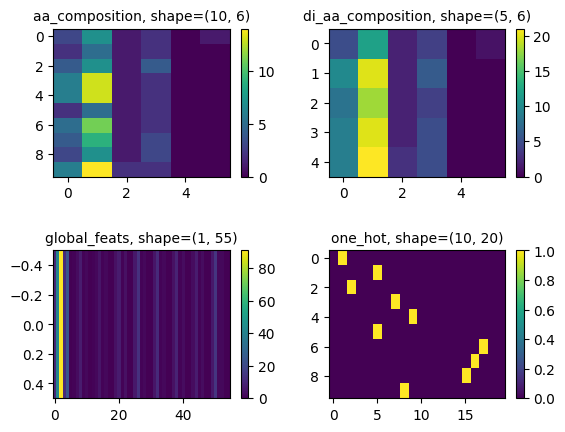

---
RAMPLES: 


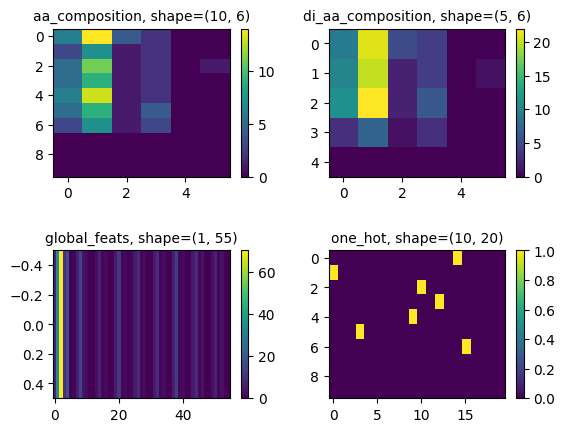

---
SAMPLER: 


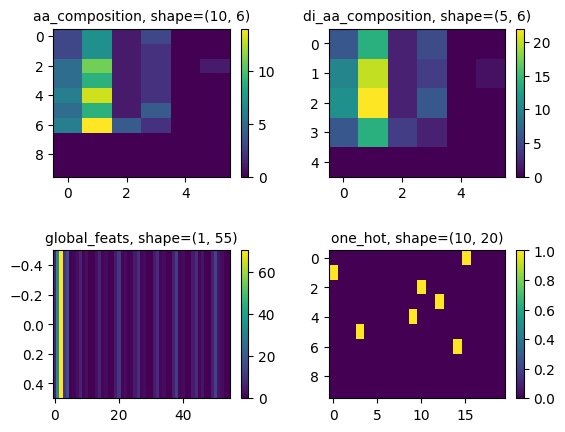

---
SAMPLER[Methylation]: 


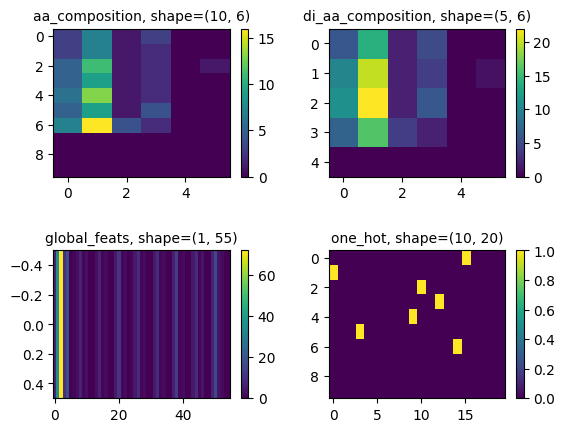

---
S[Phosphorylation]AMPLER: 


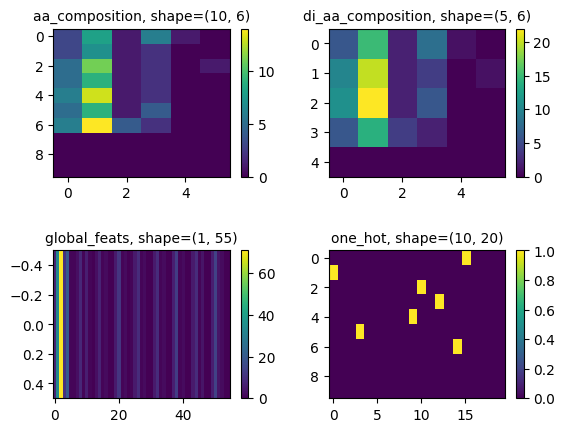

---


In [ ]:
### Example ###

"""
Although the paper padded all peptides to a length of 60, To avoid excessive
padding, I adjusted the matrix length to match the length of the largest_peptide.
to make the visualization clearer.
"""
peptides = ["CGDILGVTSK","RAMPLES", "SAMPLER", "SAMPLER[Methylation]", "S[Phosphorylation]AMPLER"]
peptides = list(map(lambda x: break_into_aa(x),peptides)) # Regex function to help parse PTMs
largest_peptide = max(len(item) for item in peptides)

for peptide in peptides:
    embedding_dict = deepLC_embedding(peptide, largest_peptide)
    peptide = ''.join(peptide)
    print(f'{peptide}: ')

    # **See actual array**
    # pprint.pprint(embedding_dict)

    # **Visualize as a heatmap** (prettier)
    plot_heatmap_subplots(embedding_dict)
    print('---')




---

**Take a moment** to see if you can see the differences between the different peptides and different PTMs!

Do you see the difference between `SAMPLER`, `S[Phosphorylation]AMPLER`, and `SAMPLER[METHYLATION]`?

---



## Wrap up:

The goal of this chapter was to walk you through one way that we can combine multiple different ways to represent our peptide into one object--- a tensor.

Although it might of been a little bit tedious, hopefully taking the time to code throguh the different embedding methods will help you be mindful of the embedding methods that you use in your own ML projects.

It will also let you appreciate the [next chapter](https://colab.research.google.com/drive/1e3E8HcGstGyOznk98vBaUFa3DqVLQMlM?usp=sharing) even more!